![logo sorbonne universite](rough_interface/logo_sorbonne2.png)
# Modélisation de la réflexion d'une onde à une interface rugueuse
## Avancement de l'étude

Dans ce notebook sera consigné quelques résultats obtenus pour le projet de modélisation de la réflexion d'une onde à une interface rugueuse. Ce notebook peut également servir d'aide à la compréhension de l'utilisation de la classe *RoughInterfaceScattering*

On importe les librairies nécessaires

In [13]:
import rough_interface as ri
from rough_interface.timeit import ProgressBar
import numpy as np
from scipy.optimize import minimize as mini
from scipy.io import loadmat
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
cart_real = lambda p,pb: plt.imshow(np.real(p.reshape([pb.res,pb.res])),\
                               origin='lower',vmin=-pb.amplitude,vmax=pb.amplitude,\
                               extent = pb.extent,interpolation='bicubic',cmap='RdBu')

cart_abs = lambda p,pb: plt.imshow(abs(p.reshape([pb.res,pb.res])),\
                               origin='lower',vmin=0,vmax=pb.amplitude,\
                               extent = pb.extent,interpolation='bicubic',cmap='afmhot')

In [15]:
pb = ri.RoughInterfaceScattering()

In [16]:
rms = lambda x: np.sqrt(np.mean(np.power(x,2)))

# Convergence du schéma en fonction de $N$
Cette partie est destinée à étudier la convergence du schéma en fonction du paramètre $N$.
On pour cela créer une interface plane de longueur 10m, et augmenter le nombre points au fur et à mesure.

In [ ]:
from time import time

pb.create_interface('s_unique',0,1,2,5)
pb.set_source('ponctuelle',[0,3])
pb.set_frequency(200)
pb.set_omega([-5,5,-5,5],100,.2)
pb.set_circle(2,[0,0])

simulation = [pb.start()[0]]
duration = []

N = np.linspace(5,500,30)

for i,n in enumerate(N):
    start = time()
    n = int(n)
    print n
    pb.create_interface('s_unique',0,1,n,5)
    simulation.append(pb.start(quiet=True)[0])
    duration.append(time()-start)
    

In [ ]:
convergence = []
for i in range(len(simulation)-1):
    convergence.append(rms(abs(simulation[i]-simulation[i+1]))/rms(abs(simulation[i])))
convergence = np.asarray(convergence)

In [ ]:
plt.plot(N*1.7/10.,100*convergence,'r')
plt.xlabel('Nombre de points par longueur d\'onde')
plt.ylabel('Erreur (%)')
plt.yscale('log')
plt.grid()
plt.savefig('convergence.eps')
plt.show()

plt.plot(N*1.7/10.,duration,'b')
plt.xlabel('Nombre de points par longueur d\'onde')
plt.ylabel('Temps de calcul (s)')
plt.grid()
plt.savefig('temps.eps')
plt.show()

# Caractérisation de la rugosité
Dans cette partie on cherche à montrer l'influence de la rugosité sur la réflexion

In [35]:
pb = ri.RoughInterfaceScattering()

pb.set_source('plane',[0,5])
pb.set_angle(np.pi/3)
pb.set_omega([-5,5,-1,9],150,2)
pb.set_circle(2,[0,0])
pb.set_frequency(200)

In [36]:
f_ref = 2000 #On fixe une taille de rugosité comparable à la longueur d'onde pour f= 1000Hz
taille = 340/float(f_ref)
print "Taille de rugosité = {}".format(taille)

Taille de rugosité = 0.17


In [37]:
#frequences = 2*np.logspace(1,3,30)
#frequences = np.linspace(1000,5000,5)
frequences = np.logspace(3,np.log10(6000),20)
#frequences = [2000,3000]
frequences = np.asarray(frequences)
print frequences

progress = ProgressBar()


pb.create_interface('s_sinusoidale',0,taille,1500,15)
#pb.start()

[1000.         1098.89280277 1207.56539197 1326.9849181  1458.21417588
 1602.42106277 1760.88897288 1935.02821876 2126.38858275 2336.67310946
 2567.75326241 2821.68557933 3100.7299748  3407.36985263 3744.33420741
 4114.62191167 4521.52840484 4968.67502158 5460.04122049 6000.        ]


In [38]:
ref = []
progress.set_total(len(frequences))

#On calcule les références
for i,f in enumerate(frequences):
    progress.set_current(i)
    pb.set_frequency(f)
    ref.append(pb.start(quiet=True)[0])

05%
10%
15%
20%
25%
30%
35%
40%
45%
50%
55%
60%
65%
70%
75%
80%
85%
90%
95%


In [39]:
sim = []
pb.create_interface('s_sinusoidale',taille,taille,1500,15)

progress.reset()
progress.set_total(len(frequences))
#On calcule les simulations
for i,f in enumerate(frequences):
    progress.set_current(i)
    pb.set_frequency(f)
    sim.append(pb.start(quiet=True)[0])

00%
05%
10%
15%
20%
25%
30%
35%
40%
45%
50%
55%
60%
65%
70%
75%
80%
85%
90%
95%


In [40]:
lam = 340/frequences
rayleigh = list(pb.rms * np.cos(pb.angle) < lam/8.).index(False)
critere = 340/(8*pb.rms*np.cos(pb.angle))
critere

1414.582160453407

In [41]:
diff = []
alpha = []
sim = np.asarray(sim)
ref = np.asarray(ref)

erreur = lambda x,y: rms(abs(x-y))/rms(abs(x)) #Création d'un shortcut ERREUR
arr2cmplx = lambda x: x[0] + 1j*x[1]


for i in range(len(ref)):
    r = ref[i].reshape([150,150])[35:,:]
    s = sim[i].reshape([150,150])[35:,:]
    
    coef = mini(lambda x: rms(abs(r*arr2cmplx(x)-s)),[1,1],method='Powell').x
    
    err = erreur(s,arr2cmplx(coef)*r)
    alpha.append(arr2cmplx(coef))
    diff.append(err)
alpha = np.asarray(alpha)
diff = np.asarray(diff)

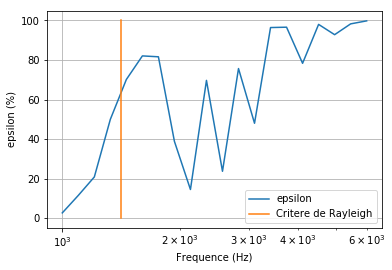

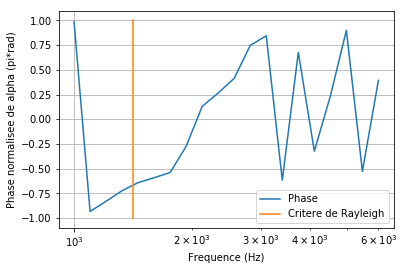

In [42]:

plt.plot(frequences,(100*abs(diff)))
plt.plot([critere,critere],[0,100])
plt.grid()
plt.xlabel('Frequence (Hz)')
plt.ylabel('epsilon (%)')
plt.xscale('log')
plt.legend(['epsilon','Critere de Rayleigh'])

plt.savefig('erreur_angle_{}_aleatoire_{}_{}.eps'.format(int(pb.angle*180/3.14),int(frequences[0]),\
           int(frequences[-1])))

plt.show()

plt.plot(frequences, np.angle(alpha)/np.pi)
plt.plot([critere,critere],[-1,1])
plt.grid()
plt.xlabel('Frequence (Hz)')
plt.ylabel('Phase normalisee de alpha (pi*rad)')
plt.xscale('log')
plt.legend(['Phase','Critere de Rayleigh'])
plt.savefig('phase_angle_{}_aleatoire_{}_{}.eps'.format(int(pb.angle*180/3.14),int(frequences[0]),\
           int(frequences[-1])))
plt.show()

## Exploration du truc chelou à 10e3 Hz
On va chercher à voir ce qu'il se passe, vraisemblablement c'est $\frac{\lambda}{2}$-périodique.

In [ ]:
pb.set_frequency(300)
pb.set_angle(np.pi/3.)
pb.start()

# Photo de couverture
On cherche à obtenir une jolie cartographie de pression



In [ ]:
pb.create_interface('s_aleatoire',2,1.5,200,10)
pb.set_source('ponctuelle',[0,5])
pb.set_frequency(200)
pb.set_omega([-12,12,-2,22],200,.2)
pb.set_circle(2,[2,2])
p,d = pb.start(quiet=False)

In [ ]:
cart_real(p,pb)
plt.savefig('joli.eps')

# Deuxième validation avec une interface triangle
Dans cette partie, on simule via kwave et RIS le même problème, et on trace la comparaison entre les deux résultats

In [ ]:
from rough_interface import geometry,affichage

pb = ri.RoughInterfaceScattering()

In [ ]:
lam = 1

pb.create_interface('s_unique',2.5,2.5,1500,20)
pb.set_source('ponctuelle',[0,7.5])
pb.set_omega([-10*lam,10*lam,-10*lam,10*lam],150,.1)
pb.set_frequency(lam*340)
pb.cercle = zip(np.linspace(-10,10,1000),2.5*np.ones(1000))

In [ ]:
p,d = pb.start(quiet=False)

In [ ]:
kwave = loadmat('validation_reflexion_ponctuelle.mat')['RMS'][0]

plt.plot(np.linspace(-10,10,1000),20*abs(d))
plt.plot(np.linspace(-10,10,1000),20*abs(d+np.random.rand(1000)*.005)-.2)
plt.grid()
plt.legend(['RIS','K-WAVE'])
plt.savefig('comparaison_validation_2.eps')
plt.show()

In [ ]:
from scipy.io import loadmat

kwave = loadmat('troisiemevalidation.mat')['a'][0]

plt.plot(np.linspace(-10,10,128),kwave-1)
plt.plot(np.linspace(-10,10,1000),abs(d))
plt.legend(['kwave','RIS'])
plt.grid()



# Réflexion non classique
On remarque que lorsque on utilise une interface sinusoidale avec un certain jeu de paramètres (voir ci dessous), on obtient des couloirs dans l'amplitude de l'onde réfléchie.

In [ ]:
import rough_interface as ri
pb = ri.RoughInterfaceScattering()
pb.create_interface('s_aleatoire',1.5 ,.5,500 ,5)
pb.set_source('ponctuelle',[0,5])
pb.set_frequency(200)
pb.set_omega([-5,5,-2,7],150 ,.2)
pb.set_circle(2,[0,0])
p,d = pb.start()

In [ ]:
pb.create_interface('s_sinusoidale',.30,1.7,1500,50)
pb.set_source('plane',[0,5])
pb.set_frequency(200)
pb.set_omega([-5,5,-2,7],150,2)
pb.set_circle(2,[0,0])
pb.set_angle(30*3.14/180)

p,d = pb.start()

**On cherche à identifier le nombre d'onde**

In [ ]:
p = p.reshape([pb.res,pb.res])

In [ ]:
ligne = np.real(p[75,:])*np.hanning(150)
plt.plot(ligne)
plt.title('Periodicite de la reflexion')
plt.grid()
plt.xlabel('Position (m)')
plt.ylabel('Amplitude (u/a)')
plt.show()

fs = 15
Nfft = 8192

l_ = np.fft.fft(ligne,Nfft)
f = np.linspace(0,fs,Nfft)


plt.plot(f,20*np.log10(abs(l_)))
plt.xlim([0,fs/2.])
plt.grid()
plt.title('Spectre de la reflexion')
plt.xlabel('Frequence spatiale')
plt.ylabel('Amplitude')
plt.show()

kx = f[np.argmax(abs(l_[0:Nfft/2]))]

print('Nombre d\'onde: {}'.format(kx))

lam_assoc = 1/kx

print('Longueur d\'onde: {}'.format(lam_assoc))

tetha = np.arcsin(340.*kx/pb.omega)

print tetha*180/3.14

# Hypothèse onde plane
**On rapppele le critère de Rayleigh:**
\begin{align}
\sigma \cos (\theta) &< \frac{\lambda}{8} \\
\gamma \cos (\theta) &< \frac{\lambda}{8}
\end{align}

**Le critère de Rayleigh n'est pas une valeur intrinsèque, une interface peut être lisse pour une fréquence et un angle donné, et rugueux pour un autre couple de paramètres.**

*Attention, dans cette partie, le nombre d'élément est grand ($\approx 1500$) et donc peut conduire à des temps de calcul assez longs*

On se place dans le cadre d'une interface *aléatoire*.

In [ ]:
lam = 340/pb.f

pb.create_interface('s_aleatoire',.4*lam,.4*lam,1500,30)
pb.set_omega([-5,5,-2,7],150,2)
p,d = pb.start(quiet = True)

On affiche la cartographie de pression.

In [ ]:
cart_real(p,pb)
plt.title('Cartographie de la pression rayonnee')
plt.show()

On voit qu'il y a a peu près un comportement d'onde plane très bruité, on va chercher à quantifier à quel point. Pour ce faire, on va calculer le cas idéal d'une onde réfléchie plane.

In [ ]:
pb.create_interface('s_aleatoire',0,1,1500,30)
p_ref,d = pb.start(quiet=True)
cart_real(p_ref,pb)
plt.title('Cartographie de la pression de reference')
plt.show()

Pour objectivement comparer les deux cartographies, on va calculer l'écart entre les deux pour chaque point au dessus de l'interface.

In [ ]:
def calcul_erreur(p,p_ref,crop):
    """Fonction qui à deux cartographies données renvoie la valeur RMS de l'erreur entre
    leur différence."""
    p_c = p.reshape([pb.res,pb.res])[crop:,:] #On reshape et on crop les cartographies
    p_ref_c = p_ref.reshape([pb.res,pb.res])[crop:,:]

    rms = lambda x:np.sqrt(np.mean(np.power(x,2))) #Création d'un shortcut RMS
    erreur = lambda x,y: rms(abs(y-x))/rms(abs(x)) #Création d'un shortcut ERREUR
    coef = mini(lambda a: erreur(p_ref_c,a*p_c),1).x[0] #Minimisation de l'erreur pour coef

    print('On obtient une erreur de {0}%, a={1:.2f}'.\
          format(int(100*erreur(p_ref_c,coef*p_c)),coef))
    if pb.rms*np.cos(pb.angle) < lam/8.:
        print('Surface lisse au sens de Rayleigh')
    else:
        print('Surface rugueuse au sens de Rayleigh')

In [ ]:
calcul_erreur(p,p_ref,35)

Pour une interface présentant une rugosité de taille $0.4\lambda$, on obtient une onde réfléchie plane à $\approx5\%$, et rugueuse au sens de Rayleigh. On va diminuer la taille de la rugosité à $0.1\lambda$.

In [ ]:
pb.create_interface('s_aleatoire',.1*lam,.1*lam,1500,30)
p,d = pb.start(quiet=True)

In [ ]:
calcul_erreur(p,p_ref,35)

Pour une interface présentant des rugosités de l'ordre de $0.1\lambda$, on arrive à une onde réfléchie qui est à $\approx 70\%$ plane. On passe à $0.05\lambda$.

In [ ]:
pb.create_interface('s_aleatoire',.05*lam,.05*lam,1500,30)
p,d = pb.start(quiet=True)
calcul_erreur(p,p_ref,35)

Pour une interface présentant des rugosités de l'ordre de $0.05\lambda$, on obtient une onde réfléchie plane à $\approx 80\%$. On passe à $0.02\lambda$.

In [ ]:
pb.create_interface('s_aleatoire',.02*lam,.02*lam,1500,30)
p,d = pb.start(quiet=True)
calcul_erreur(p,p_ref,35)

Ici, on obtient une onde réfléchie plane à $\approx 95\%$. Le premier ressenti provenant de ces résultats et que le critère de Rayleigh est bien représentatif pour une interface aléatoire